In [29]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.stats as stats
import pandas as pd
import glob
import os
import requests
import json

path = "Resources"

In [2]:
# Read property csv
input_file = "Property_Data_Postcodes.csv"
input_path = os.path.join(path, input_file)
property_data = pd.read_csv(input_path)
property_data.drop(property_data.columns[[0,2]], axis=1, inplace=True)
property_data.columns = property_data.columns.str.removeprefix("Median ")
property_data = property_data.dropna(how="any")
property_data = property_data.set_index("locality")
property_data = property_data.astype(int)
property_data.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
locality,,,,,,,,,,
Abbotsford,792500,862500,925000,1187500,1280000,1192500,1050000,1200000,1375000,1517500
Aberfeldie,947500,1045000,1207500,1300000,1471000,1498500,1390000,1520000,1880500,1575000
Aireys Inlet,664000,625500,680000,715000,737500,869000,985000,1132500,1775000,1750000
Airport West,532000,575000,635000,742000,845000,845000,795000,812500,960000,919500
Albanvale,313000,328000,345000,439000,526500,546000,512000,545000,610000,605000


In [3]:
# Add column for % increase over the decade
property_data["%_incr"] = round((property_data["2022"] - property_data["2013"]) / property_data["2013"] * 100,2)
property_data.sort_values(by="%_incr", ascending=False, inplace=True)
property_data.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,%_incr
locality,,,,,,,,,,,
Bundalong,337500,336500,372500,425000,373000,462000,515000,725000,674500,3400000,907.41
Marysville,180000,125000,320000,332500,383000,477500,462500,475000,670000,980000,444.44
Flinders,765000,808000,839000,1225000,1525000,1697500,1670000,2085000,2667500,3845000,402.61
Chewton,312500,296000,369000,403500,320000,435000,439500,605000,672500,1550000,396.00
Connewarre,612500,722500,800000,892000,955000,1200000,1345000,1647500,1625000,2842500,364.08


In [4]:
# Define quartile bins and put each suburb in a bin
quartiles = property_data["%_incr"].quantile([0.25, 0.5, 0.75])
property_data.loc[property_data["%_incr"] <= quartiles[0.25], "Quartile"] = 1
property_data.loc[(property_data["%_incr"] > quartiles[0.25]) & (property_data["%_incr"] <= quartiles[0.5]), "Quartile"] = 2
property_data.loc[(property_data["%_incr"] > quartiles[0.5]) & (property_data["%_incr"] <= quartiles[0.75]), "Quartile"] = 3
property_data.loc[property_data["%_incr"] > quartiles[0.75], "Quartile"] = 4
property_data.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,%_incr,Quartile
locality,,,,,,,,,,,,
Bundalong,337500,336500,372500,425000,373000,462000,515000,725000,674500,3400000,907.41,4.0
Marysville,180000,125000,320000,332500,383000,477500,462500,475000,670000,980000,444.44,4.0
Flinders,765000,808000,839000,1225000,1525000,1697500,1670000,2085000,2667500,3845000,402.61,4.0
Chewton,312500,296000,369000,403500,320000,435000,439500,605000,672500,1550000,396.00,4.0
Connewarre,612500,722500,800000,892000,955000,1200000,1345000,1647500,1625000,2842500,364.08,4.0


In [5]:
output_file = "property_data_quartiles.csv"
output_path = os.path.join(path, output_file)
property_data.to_csv(output_path) 

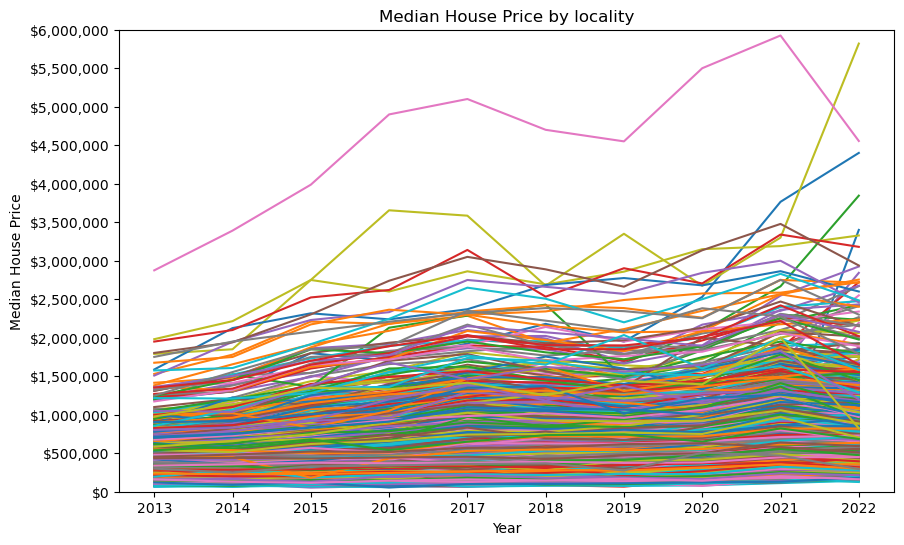

In [6]:
# Plot the median house price lines for each locality
plt.figure(figsize=(10, 6))

years = [heading for heading in property_data.columns if heading not in ["%_incr", "Quartile"]]

for locality in property_data.index:
    plt.plot(property_data.loc[locality, years])

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('Median House Price')

# Set the plot title
plt.title('Median House Price by locality')

# format y-axis ticks as dollar values with commas
def currency_formatter(x, p):
    return '${:,.0f}'.format(x)

plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(currency_formatter))

plt.ylim([0, 6000000])

yticks = [i*500000 for i in range(13)]
plt.yticks(yticks)

output_file = "med_house_by_locality.png"
output_path = os.path.join(path, output_file)
plt.savefig(output_path)

# Show the plot
plt.show()

In [23]:
# Read crime files in a loop using wildcards
file_list = glob.glob(os.path.join(path, "[A-F]*.csv"))

# Pivot each crime file and save with '_wide' appended to name
for file_path in file_list:
    # Read csv
    df = pd.read_csv(file_path)
    # Clean file
    df = df.drop("Median", axis=1)
    df = df.groupby(["Year", "Local Government Area", "Postcode", "Suburb/Town Name"], as_index=False)["Offence Count"].sum().sort_values(["Suburb/Town Name", "Year"])
    # Pivot crime dataframe to have suburbs in each row and years in columns
    df_pivot = df.pivot(index='Suburb/Town Name', columns='Year', values='Offence Count')
    # Replace missing values with 0
    df_pivot.fillna(0, inplace=True)
    # Merge with the original dataframe to add the Postcode and Local Government Area columns
    df_final = df_pivot.merge(df[['Suburb/Town Name', 'Postcode', 'Local Government Area']].drop_duplicates(), on='Suburb/Town Name')[['Suburb/Town Name', 'Postcode', 'Local Government Area'] + list(df_pivot.columns)]
    # Sort the rows alphabetically by suburb name
    df_final.sort_values(by='Suburb/Town Name', inplace=True)
    # Set the Suburb column as the index
    df_final.set_index('Suburb/Town Name', inplace=True)
    # Save with new name
    file_name = os.path.basename(file_path)
    file_part = os.path.splitext(file_name)[0]
    output_path = os.path.join(path, f"{file_part}_wide.csv")
    df_final.to_csv(output_path)

In [24]:
# Add columns for %_crime_change and crime_quartile and merge with %_incr from property data
file_list = glob.glob(os.path.join(path, "[A-F]*_wide.csv"))

# Use a loop to process each wide crime file
for file_path in file_list:
    file_name = os.path.basename(file_path)
    file_part = os.path.splitext(file_name)[0].rsplit("_")[0]
    output_path = os.path.join(path, f"{file_part}_quartiles.csv")

    # Read csv
    df = pd.read_csv(file_path)

    # Drop null lines
    df = df.dropna(how="any")

    # add %_change column (0.1 is added to denominator to supress divide by zero error)
    df["%_crime_change"] = round((df["2022"] - df["2013"]) / (df["2013"]+0.1) * 100,2)
    df.sort_values(by="%_crime_change", ascending=False, inplace=True)

    # Define quartile bins and put each suburb in a bin
    quartiles = df["%_crime_change"].quantile([0.25, 0.5, 0.75])
    df.loc[df["%_crime_change"] <= quartiles[0.25], "crime_quartile"] = 1
    df.loc[(df["%_crime_change"] > quartiles[0.25]) & (df["%_crime_change"] <= quartiles[0.5]), "crime_quartile"] = 2
    df.loc[(df["%_crime_change"] > quartiles[0.5]) & (df["%_crime_change"] <= quartiles[0.75]), "crime_quartile"] = 3
    df.loc[df["%_crime_change"] > quartiles[0.75], "crime_quartile"] = 4

    # Add suburb %_increase in median property value from property_data
    df = df.merge(property_data.reset_index()[["locality", "%_incr"]], left_on=["Suburb/Town Name"], right_on = ["locality"], how = 'inner').rename(columns={"%_incr": "%_property_incr"}).drop('locality', axis=1)
    df.set_index('Suburb/Town Name', inplace=True)

    # Write file to output folder
    df.to_csv(output_path)
    os.remove(file_path)

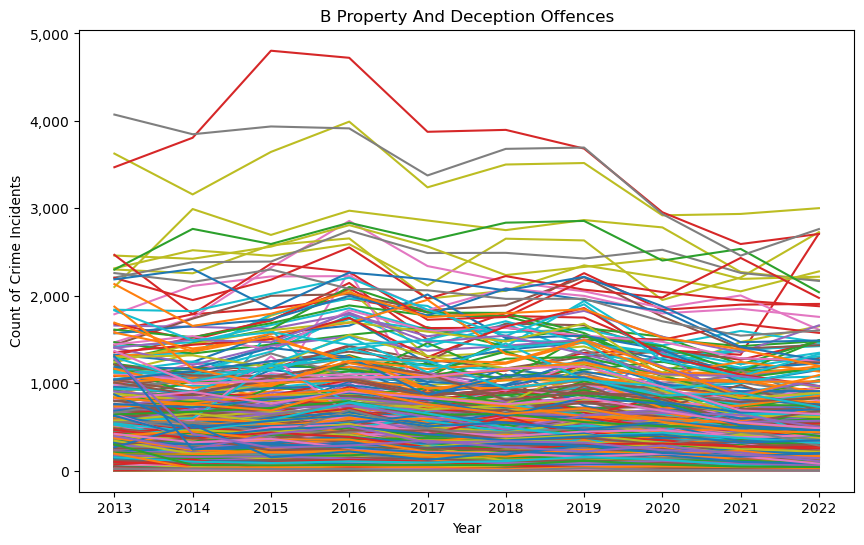

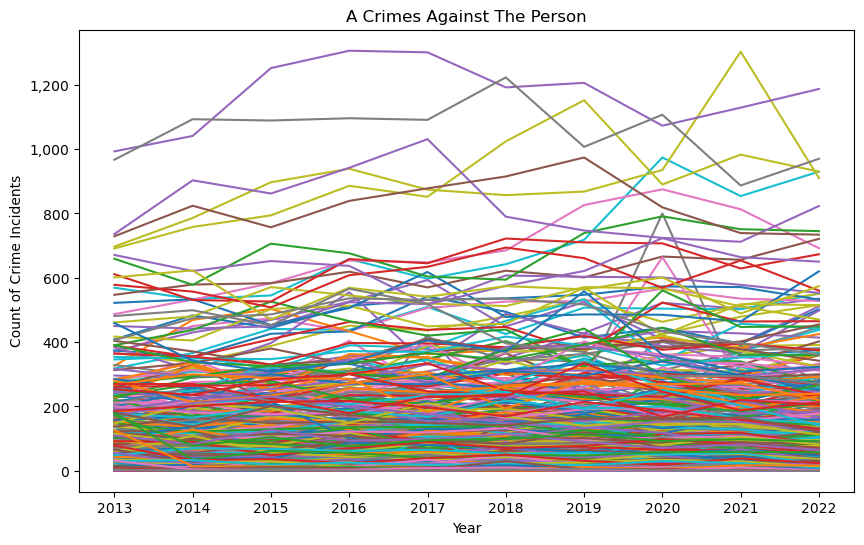

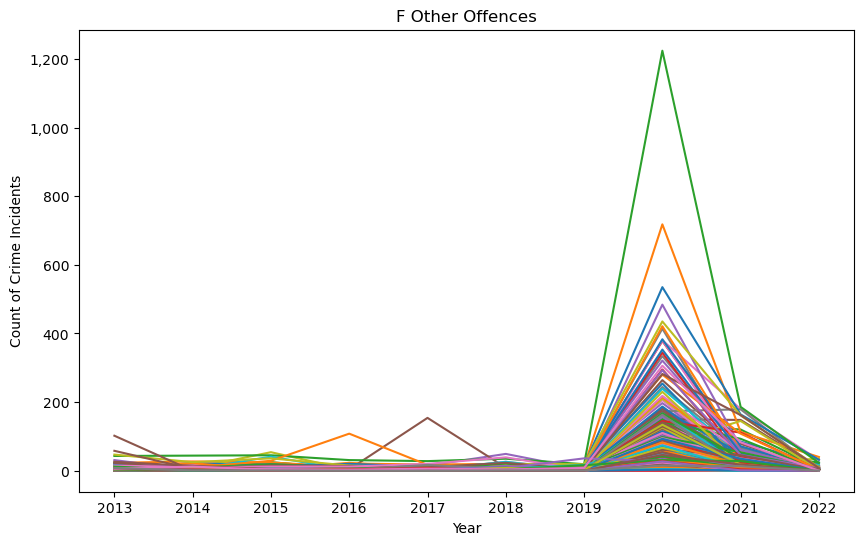

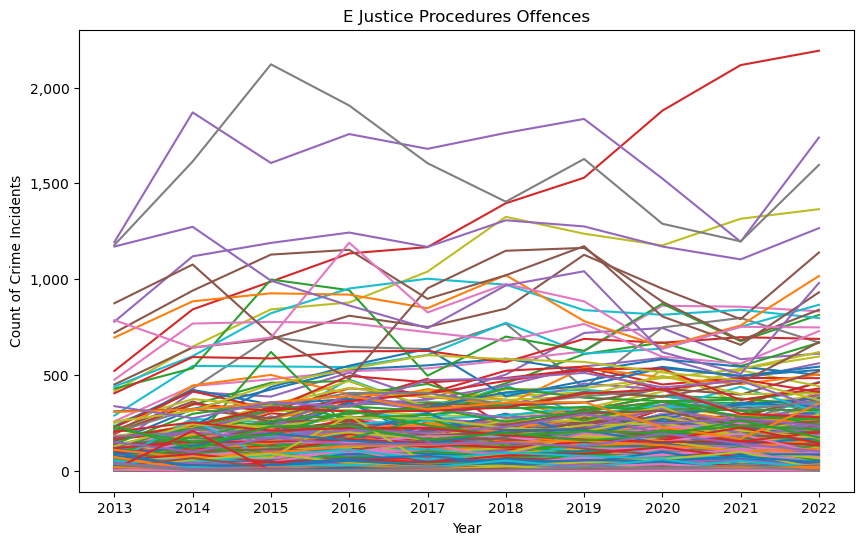

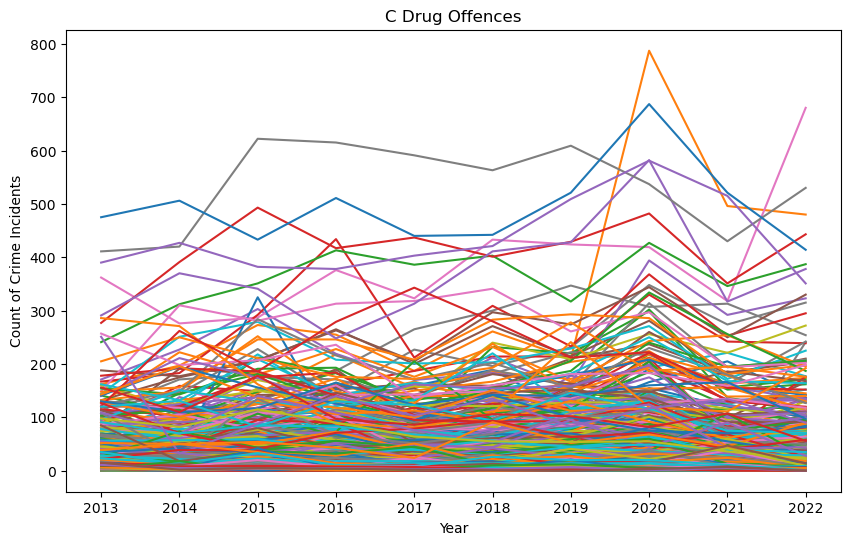

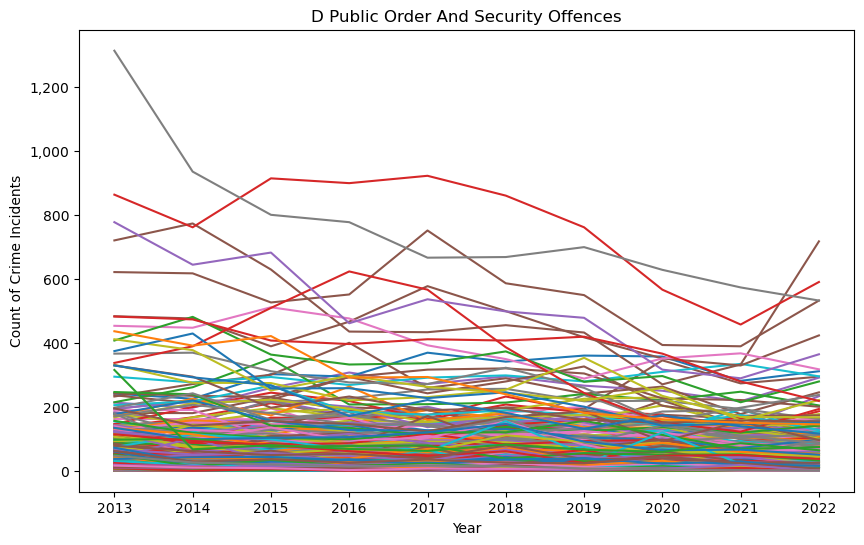

In [25]:
# Plot crime lines for each locality
file_list = glob.glob(os.path.join(path, "[A-F]*_quartiles.csv"))

for file_path in file_list:
    file_name = os.path.basename(file_path)
    file_part = os.path.splitext(file_name)[0].rsplit("_")[0]
    output_path = os.path.join(path, f"{file_part}_plot.png")

    # Read csv
    df = pd.read_csv(file_path)
    df.set_index('Suburb/Town Name', inplace=True)

    plt.figure(figsize=(10, 6))

    years = [heading for heading in df.columns if heading not in ["Postcode", "Local Government Area", "%_crime_change", "crime_quartile", "%_property_incr"]]

    for suburb in df.index:
        plt.plot(df.loc[suburb, years])

    # Set the x-axis label
    plt.xlabel('Year')

    # Set the y-axis label
    plt.ylabel('Count of Crime Incidents')

    # Set the plot title
    plt.title(str.title(file_part))

    # format y-axis ticks as dollar values with commas
    def comma_formatter(x, p):
        return '{:,.0f}'.format(x)

    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(comma_formatter))

    # Save plot
    plt.savefig(output_path)

    # Show the plot
    plt.show()

In [ ]:
# Trying to get suburb population data from ABS but no success :(
# API Base URL=Base URL: api.data.abs.gov.au, string= agencyID="ABS", Dataflow id="ABS_ANNUAL_ERP_LGA2019   C21_G01_SAL   ABS_REGIONAL_LGA2021", version="1.0.0"
url = "https://api.data.abs.gov.au/dataflow/ABS/C21_G01_SAL/1.0.0?"
# url = "https://api.data.abs.gov.au/dataflow/ABS/C21_G01_SAL/1.0.0?references=all"

# List of suburb/town names
suburbs = ["Melbourne", "Geelong", "Ballarat"]

# # Loop through suburbs and make GET requests
for suburb in suburbs:
    # Set request parameters
    params = {
        "region": f"LGA{suburb}",
        "time": "latest",
        "datapage": "2019",
        "start": "1",
        "limit": "1"
    }
#     # Set request headers
    headers = {
        "Accept": "application/json"
    }
#     # Make GET request
# response = requests.get(url)
    response = requests.get(url, params=params, headers=headers)
    # print(params)
    # print(response)
    # Parse JSON response
    # data = json.loads(response.text)
    # # Get population statistics
    # population = data["data"][0]["value"]
    # # Print results
    # print(f"Population of {suburb}: {population}")


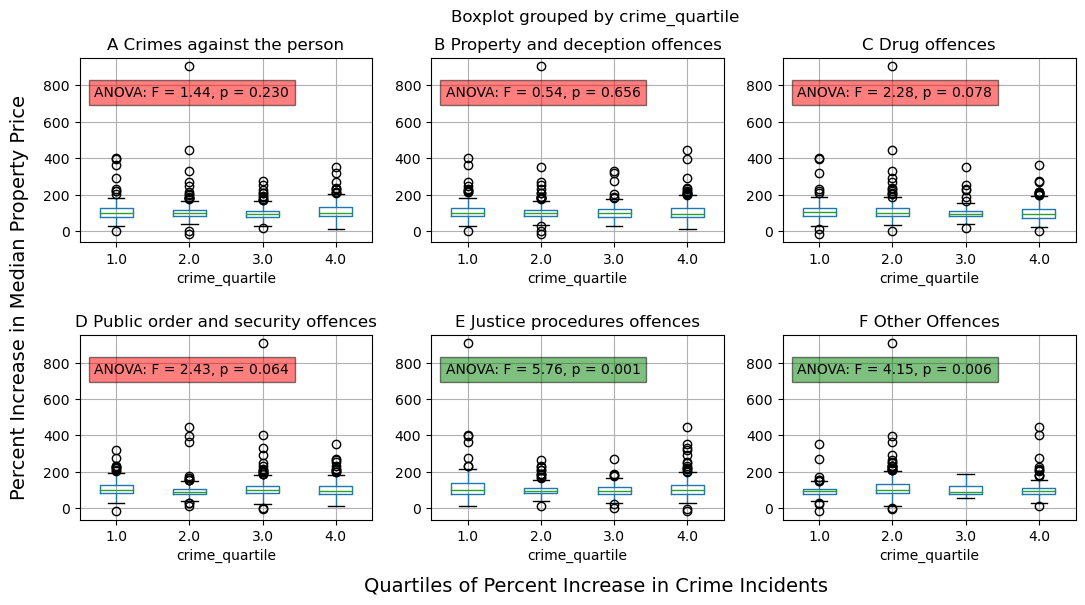

In [72]:
# Plot boxplots of %_increase in property value by crime_quartile for all crime groups and perform ANOVA
file_list = glob.glob(os.path.join(path, "[A-F]*_quartiles.csv"))

# Create a new figure
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axs = axs.flatten()

#Loop through each csv file
file_list = sorted(file_list)
for i, file_path in enumerate(file_list):
    file_name = os.path.basename(file_path)
    file_part = os.path.splitext(file_name)[0].rsplit("_")[0]
    output_path = os.path.join(path, "q_incr_crime_v_incr_price_boxplot_all.png")

    # Read csv
    df = pd.read_csv(file_path)
    df.set_index('Suburb/Town Name', inplace=True)

    # Extract quartile groups
    q1 = df[df["crime_quartile"] == 1]["%_property_incr"]
    q2 = df[df["crime_quartile"] == 2]["%_property_incr"]
    q3 = df[df["crime_quartile"] == 3]["%_property_incr"]
    q4 = df[df["crime_quartile"] == 4]["%_property_incr"]

    # Perform the ANOVA
    f_val, p_val  = stats.f_oneway(q1, q2, q3, q4)

    # Create boxplot for the current filepath and add it to the figure
    df.boxplot("%_property_incr", by="crime_quartile", figsize=(15, 10), ax=axs[i])

    # Add ANOVA result to boxplot as text
    if p_val < 0.05:
        bbox_color = 'green'
    else:
        bbox_color = 'red'
    axs[i].text(0.05, 0.85, f'ANOVA: F = {f_val:.2f}, p = {p_val:.3f}', ha='left', va='top', transform=axs[i].transAxes, bbox=dict(facecolor=bbox_color, alpha=0.5))

    # set the title of the subplot
    axs[i].set_title(file_part)

    # Set the plot title
    plt.title(str.title(file_part))

# set x and y axis labels for all subplots
fig.text(0.5, 0.02, "Quartiles of Percent Increase in Crime Incidents", ha='center', va='center', fontsize = 14)
fig.text(0.02, 0.5, "Percent Increase in Median Property Price", ha='center', va='center', rotation='vertical', fontsize = 14)

# adjust the spacing between the subplots
fig.subplots_adjust(wspace=0.2, hspace = 0.5, left = 0.07, bottom = 0.13)

# Save plot
plt.savefig(output_path)

# Show the plot
plt.show()